# Projet Télédétection Avancée UE:901_2  + Qualité et Fouille UE: 906

NOM: DIALLO
Prénom: Djiby

Données utilisées: Bretagne_24-25 et échantillons PI_strates_Bretagne_32630


# Introduction Générale

La classification d’images de télédétection constitue une étape clé pour transformer des données brutes en cartes thématiques exploitables. Elle permet d’identifier et de discriminer différents types de surfaces (sols nus, végétation, zones artificialisées, cultures, etc.) à partir de leurs signatures spectrales. Les méthodes de classification supervisée, et notamment celles basées sur l’apprentissage automatique, offrent aujourd’hui des performances élevées et une grande capacité de généralisation, à condition d’être correctement paramétrées et validées.

Ce projet s’inscrit dans cette dynamique et vise à mettre en œuvre une chaîne complète de traitement d’images allant du prétraitement des données jusqu’à la production d’une image classifiée finale constituée des classes comme du sol nu, herbe, landes et arbre. Il mobilise des outils de traitement numérique et des bibliothèques scientifiques afin de manipuler les données raster, entraîner un modèle de classification, évaluer l’importance des variables utilisées et générer une sortie cartographique cohérente et exploitable dans un SIG.

Une attention particulière est portée à la gestion des valeurs NoData, à la cohérence radiométrique et à la compatibilité des résultats avec les logiciels de cartographie tels que QGIS. L’objectif final est de produire une carte fiable et interprétable, tout en respectant les bonnes pratiques en télédétection et en traitement des données géospatiales.

Ce travail permet ainsi de consolider des compétences à la fois théoriques et pratiques en télédétection, en analyse spatiale et en programmation appliquée, tout en répondant à des enjeux concrets de production et de qualité de l’information géographique.

### IMPORTS ET CONFIGURATION

In [1]:
# Import des bibliothèques
# et des fonctions personnalisées définies dans my_function.py
import sys
sys.path.append("/home/onyxia/work")

import os
import glob
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from osgeo import gdal, ogr
from libsigma import read_and_write as rw
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report



from my_function import (
    create_stack, 
    rasterize_vector,
    extract_stats_by_class,
    calculate_ari,
    save_raster,
    save_multiband_raster,
    prepare_training_data
)
import sys
sys.path.append("/home/onyxia/work")

import my_function as mf


### Définition des chemins

In [2]:
# Définition des chemins de travail
BASE = "/home/onyxia/work"
DATA = BASE + "/data/projet_eval"
RESULTS = BASE + "/results"
FIG = RESULTS + "/figure"

# Création des dossiers de sortie
os.makedirs(RESULTS, exist_ok=True)
os.makedirs(FIG, exist_ok=True)

# Fichiers d'entrée
vector_samples = DATA + "/PI_strates_bretagne_32630.shp"
ref_image = DATA + "/bretagne_24-25_B03.tif"


# PARTIE 1 - ANALYSE DES ÉCHANTILLONS

### Lecture des polygones d'échantillons

In [3]:
gdf = gpd.read_file(vector_samples)
print(gdf.head())


   id  strate      comment                                           geometry
0   1       3  lande basse  POLYGON ((441224.58 5366298.317, 441224.779 53...
1   2       3  lande basse  POLYGON ((441649.972 5366251.139, 441650.172 5...
2   3       3  lande basse  POLYGON ((441383.597 5366193.034, 441384.395 5...
3   4       2         None  POLYGON ((441336.658 5366402.088, 441337.257 5...
4   5       2         None  POLYGON ((441062.121 5366343.165, 441062.919 5...


### Comptage des polygones par classe

In [4]:
counts_poly = gdf["strate"].value_counts().sort_index()
print("\nNombre de polygones par classe :")
print(counts_poly)


Nombre de polygones par classe :
strate
2     86
3    121
4     71
Name: count, dtype: int64


### Création du diagramme en bâtons - Polygones

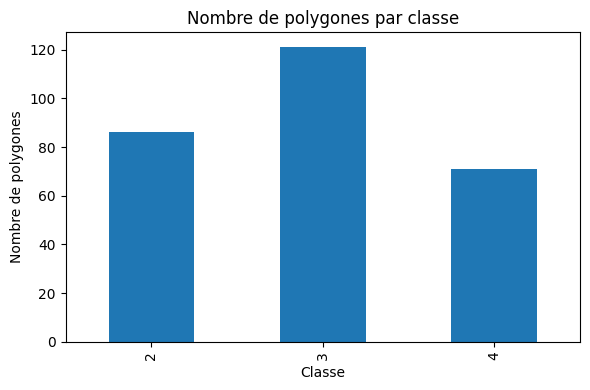

In [5]:
plt.figure(figsize=(6,4))
counts_poly.plot(kind="bar")
plt.xlabel("Classe")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par classe")
plt.tight_layout()
plt.savefig(FIG + "/diag_baton_nb_poly_by_class.png", dpi=150)
plt.show()

###  Note sur la nomenclature

Analyse des polygones d’échantillons

Le diagramme en bâtons met en évidence la présence de trois classes seulement dans les échantillons disponibles :
– classe 2 (Herbe),
– classe 3 (Landes),
– classe 4 (Arbre).

La classe 1 (Sol Nu) est absente de la base d’échantillons. Cette absence est cohérente avec le contexte breton, caractérisé par une forte couverture végétale permanente et peu de surfaces minérales nues.

En conséquence, la classification supervisée sera limitée à ces trois classes, et aucune prédiction de la classe Sol Nu ne sera possible.

#  PARTIE 2 — RASTERISATION DES ÉCHANTILLONS

###  Rasterisation à 10m de résolution

In [6]:
out_raster = RESULTS + "/strates_rasterise.tif"

ds_ref = gdal.Open(ref_image)
gt = ds_ref.GetGeoTransform()
proj = ds_ref.GetProjection()
cols = ds_ref.RasterXSize
rows = ds_ref.RasterYSize

driver = gdal.GetDriverByName("GTiff")
ds_out = driver.Create(out_raster, cols, rows, 1, gdal.GDT_Byte)
ds_out.SetGeoTransform(gt)
ds_out.SetProjection(proj)

band = ds_out.GetRasterBand(1)
band.SetNoDataValue(0)
band.Fill(0)

ds_vect = ogr.Open(vector_samples)
layer = ds_vect.GetLayer()

gdal.RasterizeLayer(ds_out, [1], layer, options=["ATTRIBUTE=strate"])

ds_out = None
ds_ref = None
ds_vect = None

print("Raster des strates créé")


Raster des strates créé


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Les polygones d’échantillons sont rasterisés à la résolution spatiale de 10 m, en utilisant la bande B03 comme image de référence pour garantir la cohérence géométrique (projection, emprise et taille de pixel).
Les pixels non échantillonnés sont codés à 0 (nodata).

### Comptage des pixels par classe

In [7]:
arr = rw.load_img_as_array(out_raster).squeeze()
vals, counts = np.unique(arr[arr > 0], return_counts=True)

print("\nNombre de pixels par classe :")
for v, c in zip(vals, counts):
    print(f"Classe {v} : {c} pixels")



Nombre de pixels par classe :
Classe 2 : 1022 pixels
Classe 3 : 1599 pixels
Classe 4 : 1218 pixels


### Création du diagramme en bâtons - Pixels

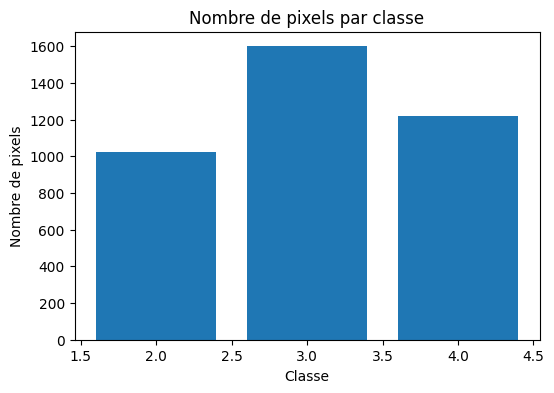

In [8]:
plt.figure(figsize=(6,4))
plt.bar(vals, counts)
plt.xlabel("Classe")
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par classe")
plt.savefig(FIG + "/diag_baton_nb_pix_by_class.png", dpi=150)
plt.show()


Les classes ne sont pas parfaitement équilibrées en nombre de pixels. La classe Landes est la plus représentée, ce qui pourra influencer l’apprentissage du classifieur supervisé et justifie l’utilisation d’une métrique pondérée lors de l’optimisation.

# PARTIE 3A - CALCUL DE L'INDICE ARI

### SÉLECTION DES BANDES B03 ET B05

In [9]:
# Les fichiers Sentinel-2 fournis sont déjà des séries temporelles :
# chaque bande du GeoTIFF correspond à une date de la série
stack_B03 = DATA + "/bretagne_24-25_B03.tif"
stack_B05 = DATA + "/bretagne_24-25_B05.tif"

# Chargement
B03 = rw.load_img_as_array(stack_B03).astype("float32")
B05 = rw.load_img_as_array(stack_B05).astype("float32")

print("Shape B03 :", B03.shape)
print("Shape B05 :", B05.shape)



Shape B03 : (612, 1533, 6)
Shape B05 : (612, 1533, 6)


Les bandes B03 (vert) et B05 (red-edge) sont utilisées pour le calcul de l’indice ARI.
La cohérence temporelle est vérifiée en contrôlant que le nombre de dates est identique pour les deux bandes.

### Chargement et calcul de l'ARI

In [10]:
B03 = rw.load_img_as_array(stack_B03).astype("float32")
B05 = rw.load_img_as_array(stack_B05).astype("float32")

np.seterr(divide="ignore", invalid="ignore")
ARI = (1.0/B03 - 1.0/B05) / (1.0/B03 + 1.0/B05)
ARI[np.isnan(ARI)] = -9999


### Sauvegarde de la série temporelle ARI

In [11]:
out_ARI = RESULTS + "/ARI_serie_temp.tif"
ds_ref = gdal.Open(stack_B03)
driver = gdal.GetDriverByName("GTiff")

rows, cols, nb_dates = ARI.shape

ds_out = driver.Create(out_ARI, cols, rows, nb_dates, gdal.GDT_Float32)
ds_out.SetGeoTransform(ds_ref.GetGeoTransform())
ds_out.SetProjection(ds_ref.GetProjection())

for i in range(nb_dates):
    band = ds_out.GetRasterBand(i+1)
    band.WriteArray(ARI[:,:,i])
    band.SetNoDataValue(-9999)

ds_out = None
ds_ref = None

print("Série temporelle ARI sauvegardée")

Série temporelle ARI sauvegardée


### Vérification des caractéristiques du raster ARI créé

In [12]:
ari_file_path = out_ARI
mf.print_raster_info(ari_file_path)
driver = gdal.GetDriverByName("GTiff")


---- Informations du raster ----
Résolution spatiale X : 10.0 m
Résolution spatiale Y : 10.0 m
Type d’encodage : Float32
Valeur NoData : -9999.0
Projection : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


# PARTIE 3B - ANALYSE PHÉNOLOGIQUE

### Extraction des statistiques par classe

In [13]:
# Extraction des statistiques ARI par classe

ARI_loaded = rw.load_img_as_array(out_ARI)
strates = rw.load_img_as_array(out_raster).squeeze()

classes = [2, 3, 4]  # Herbe, Landes, Arbre
nb_classes = len(classes)
nb_dates = ARI_loaded.shape[2]

# Initialisation des tableaux
moyennes = np.zeros((nb_classes, nb_dates))
ecarts_types = np.zeros((nb_classes, nb_dates))

# Calcul des statistiques
for i, classe in enumerate(classes):
    mask_classe = (strates == classe)

    for d in range(nb_dates):
        valeurs = ARI_loaded[:, :, d][mask_classe]
        valeurs = valeurs[valeurs != -9999]

        if valeurs.size > 0:
            moyennes[i, d] = np.mean(valeurs)
            ecarts_types[i, d] = np.std(valeurs)
        else:
            moyennes[i, d] = np.nan
            ecarts_types[i, d] = np.nan

print("Statistiques ARI calculées pour chaque classe et chaque date")


Statistiques ARI calculées pour chaque classe et chaque date


### Création du graphique de phénologie

La figure suivante présente l’évolution temporelle de l’indice ARI moyen par strate, ainsi que l’écart-type intra-classe. L’objectif est d’évaluer la capacité de l’ARI à discriminer la classe Landes.


=== Statistiques globales ARI par strate ===
Strate 2:
  min : 0.053645983
  max : 0.22484577
  mean: 0.15296303
  std : 0.02722788
Strate 3:
  min : 0.03926704
  max : 0.25989395
  mean: 0.14291848
  std : 0.021305667
Strate 4:
  min : 0.025869751
  max : 0.25177497
  mean: 0.11744908
  std : 0.029166808


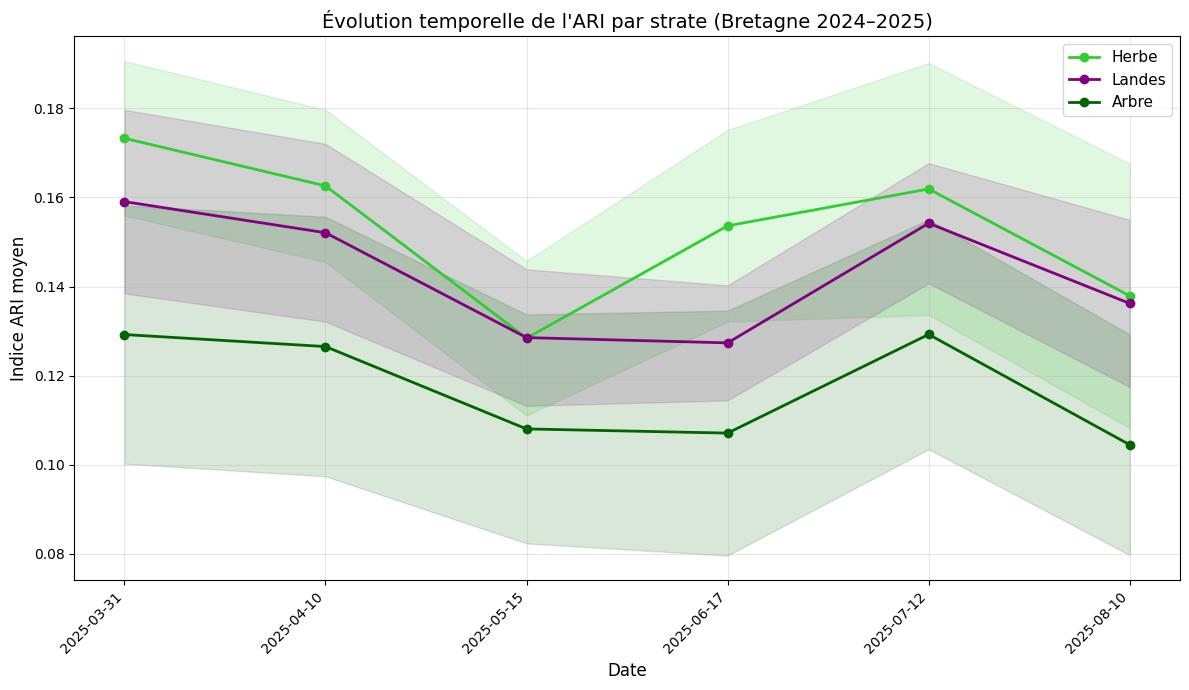

In [14]:
# Dates correspondant aux 6 acquisitions Sentinel-2 de la série Bretagne 2024–2025
dates = ["2025-03-31", "2025-04-10", "2025-05-15", 
         "2025-06-17", "2025-07-12", "2025-08-10"]

plt.figure(figsize=(12, 7))

labels = ["Herbe", "Landes", "Arbre"]
colors = ["limegreen", "purple", "darkgreen"]

print("\n=== Statistiques globales ARI par strate ===")

for i, classe in enumerate(classes):
    mask_classe = (strates == classe)

    valeurs_classe = ARI_loaded[mask_classe]
    valeurs_classe = valeurs_classe[valeurs_classe != -9999]

    print(f"Strate {classe}:")
    print("  min :", np.nanmin(valeurs_classe))
    print("  max :", np.nanmax(valeurs_classe))
    print("  mean:", np.nanmean(valeurs_classe))
    print("  std :", np.nanstd(valeurs_classe))


for i in range(3):
    plt.plot(dates, moyennes[i, :],
             label=labels[i],
             color=colors[i],
             marker='o',
             linewidth=2,
             markersize=6)

    plt.fill_between(dates,
                     moyennes[i, :] - ecarts_types[i, :],
                     moyennes[i, :] + ecarts_types[i, :],
                     alpha=0.15,
                     color=colors[i])

plt.xlabel("Date", fontsize=12)
plt.ylabel("Indice ARI moyen", fontsize=12)
plt.title("Évolution temporelle de l'ARI par strate (Bretagne 2024–2025)", fontsize=14)
plt.legend(loc="best", fontsize=11)
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG + "/ARI_series.png", dpi=150, bbox_inches="tight")
plt.show()

### Analyse de la phénologie ARI

Les valeurs moyennes de l’ARI varient globalement entre 0.10 et 0.18 pour l’ensemble des strates étudiées. Les écarts-types observés traduisent une variabilité intra-classe non négligeable, en particulier pour les classes Herbe et Landes.

La classe Herbe présente les valeurs d’ARI les plus élevées sur l’ensemble de la période, avec un maximum observé en été. La classe Landes montre un comportement temporel proche de celui de l’Herbe, avec des valeurs intermédiaires. À l’inverse, la classe Arbre présente des valeurs plus faibles et relativement plus stables dans le temps.

La classe Landes ne se distingue pas clairement des autres strates sur la base de l’ARI seul. La forte similarité de son profil temporel avec celui de l’Herbe suggère des confusions potentielles entre ces deux classes.

On observe une dynamique saisonnière marquée, avec un minimum au printemps (mai–juin) et un maximum en été (juillet), cohérente avec les cycles de végétation.

En conclusion, l’ARI seul ne permet pas une discrimination satisfaisante des Landes. Une approche multivariée intégrant l’ensemble des bandes spectrales et la dimension temporelle apparaît nécessaire pour améliorer la classification.

# PARTIE 4 - CLASSIFICATION SUPERVISÉE

### Fusion des images mono bandes en une seule image multi bande

In [15]:
# Ordre spectral explicite des bandes Sentinel-2
ordered_bands = ["B02", "B03", "B04", "B05", "B06",
                 "B07", "B08", "B8A", "B11", "B12"]

directory = "/home/onyxia/work/data/projet_eval/"

# Construction explicite des chemins
files = [
    os.path.join(directory, f"bretagne_24-25_{b}.tif")
    for b in ordered_bands
]

print("Bandes utilisées dans l'ordre :")
for f in files:
    print(" -", os.path.basename(f))

images = []

for path in files:
    ds = gdal.Open(path)
    if ds is None:
        raise IOError(f"Impossible d'ouvrir {path}")

    band = ds.GetRasterBand(1)  # première date
    arr = band.ReadAsArray().astype(np.float32)

    nodata = band.GetNoDataValue()
    if nodata is not None:
        arr[arr == nodata] = -9999

    images.append(arr)
    ds = None

output_multibande = "/home/onyxia/work/results/image_multibande_bretagne.tif"

ref_raster = os.path.join(directory, "bretagne_24-25_B03.tif")

mf.merge_and_save_multiband(
    images=images,
    output_path=output_multibande,
    reference_raster_path=ref_raster,
    nodata=-9999
)

print("✅ Image multibande créée :", output_multibande)

Bandes utilisées dans l'ordre :
 - bretagne_24-25_B02.tif
 - bretagne_24-25_B03.tif
 - bretagne_24-25_B04.tif
 - bretagne_24-25_B05.tif
 - bretagne_24-25_B06.tif
 - bretagne_24-25_B07.tif
 - bretagne_24-25_B08.tif
 - bretagne_24-25_B8A.tif
 - bretagne_24-25_B11.tif
 - bretagne_24-25_B12.tif
✅ Image multibande créée : /home/onyxia/work/results/image_multibande_bretagne.tif
✅ Image multibande créée : /home/onyxia/work/results/image_multibande_bretagne.tif


In [16]:
ds = gdal.Open(output_multibande)
print("Nombre de bandes :", ds.RasterCount)

for i in range(1, ds.RasterCount + 1):
    arr = ds.GetRasterBand(i).ReadAsArray()
    print(f"Bande {i} ({ordered_bands[i-1]}): "
          f"min={np.nanmin(arr):.1f}, max={np.nanmax(arr):.1f}, mean={np.nanmean(arr):.1f}")

ds = None

Nombre de bandes : 10
Bande 1 (B02): min=1040.0, max=5144.0, mean=1398.2
Bande 2 (B03): min=1091.0, max=5332.0, mean=1655.8
Bande 3 (B04): min=1074.0, max=5340.0, mean=1656.5
Bande 4 (B05): min=1126.0, max=4638.0, mean=2250.3
Bande 5 (B06): min=1111.0, max=6170.0, mean=3401.8
Bande 6 (B07): min=1148.0, max=7445.0, mean=3778.4
Bande 7 (B08): min=1186.0, max=7900.0, mean=4114.4
Bande 8 (B8A): min=1142.0, max=7661.0, mean=4126.9
Bande 9 (B11): min=1211.0, max=5621.0, mean=3323.1
Bande 10 (B12): min=1126.0, max=4574.0, mean=2315.5


### Production d’une carte de strates à l’échelle du pixel

In [17]:
mon_dossier = "/home/onyxia/work"

multi_band_image = "/home/onyxia/work/results/image_multibande_bretagne.tif"
sample_image_raster = os.path.join(RESULTS, "strates_rasterise.tif")

# Sample parameters
#test_size = 0.7
nb_iter = 5
nb_folds = 5
is_point = False # if is_point is True

field_name = "strate"

suffix = f"_CV{nb_folds}fold_stratified_x{nb_iter}times"

sortie_classif = os.path.join(RESULTS, "carte_strates_RF.tif")
sortie_matrix = os.path.join(RESULTS, f"ma_matrice{suffix}.png")
sortie_qualite = os.path.join(RESULTS, f"mes_qualites{suffix}.png")



In [18]:
# ============================
# Chargement des données
# ============================

X_image = rw.load_img_as_array(multi_band_image)
y_raster = rw.load_img_as_array(sample_image_raster).squeeze()

# ============================
# Préparation apprentissage
# ============================

X, Y, mask = mf.prepare_training_data(X_image, y_raster)

Y = Y.ravel()

print("X shape :", X.shape)
print("Y shape :", Y.shape)
print("Classes :", np.unique(Y))


X shape : (3839, 10)
Y shape : (3839,)
Classes : [2 3 4]


### Extraction des échantillons d'entraînement

In [19]:
# Mise en forme des labels
Y = Y.ravel()

# Split stratifié train / test (70% / 30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.3,
    stratify=Y,        # conserve proportions des classes
    random_state=42
)

print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test.shape)

# Vérification distribution des classes
print("\nDistribution classes TRAIN:")
for c, n in zip(*np.unique(y_train, return_counts=True)):
    print(f"Classe {c} : {n}")

print("\nDistribution classes TEST:")
for c, n in zip(*np.unique(y_test, return_counts=True)):
    print(f"Classe {c} : {n}")


Train : (2687, 10) (2687,)
Test  : (1152, 10) (1152,)

Distribution classes TRAIN:
Classe 2 : 715
Classe 3 : 1119
Classe 4 : 853

Distribution classes TEST:
Classe 2 : 307
Classe 3 : 480
Classe 4 : 365


### GridSearch

In [20]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],    # nombre d'arbres
    "max_depth": [None, 10, 15, 20],        # profondeur maximale des arbres (None = arbre entièrement développé)
    "max_features": [None, "sqrt", "log2"],  # nombre de variables testées à chaque split (valeurs plus faibles → plus les arbres sont différents → meilleure diversité)
    "min_samples_leaf": [1, 5],     # nombre minimal d’échantillons dans une feuille (valeurs plus grandes → arbres plus simples → moins d’overfitting)
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_weighted",   # <-- recommandé pour classes déséquilibrées
    n_jobs=-1,
    verbose=2
)

print("🚀 GridSearch en cours...")
grid.fit(X_train, y_train)

print("Meilleurs hyperparamètres trouvés :")
print(grid.best_params_)

print(f"Score CV moyen (F1 pondéré) : {grid.best_score_:.3f}")

best_model = grid.best_estimator_

🚀 GridSearch en cours...
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   1.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   1.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   1.6s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   1.9s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   1.9s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=   2.6s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=   2.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=   

### Validation croisée

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

list_cm = []
list_acc = []
list_f1 = []
list_report = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, Y), start=1):

    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]

    best_model.fit(X_train, Y_train)
    Y_pred = best_model.predict(X_test)

    # métriques globales
    cm = confusion_matrix(Y_test, Y_pred)
    acc = accuracy_score(Y_test, Y_pred)
    f1  = f1_score(Y_test, Y_pred, average="weighted")

    list_cm.append(cm)
    list_acc.append(acc)
    list_f1.append(f1)

    # rapport par classe
    report = classification_report(Y_test, Y_pred, output_dict=True)
    list_report.append(mf.report_from_dict_to_df(report))

    print(f"Fold {fold} | Accuracy = {acc:.3f} | F1_weighted = {f1:.3f}")


Fold 1 | Accuracy = 0.949 | F1_weighted = 0.949
Fold 2 | Accuracy = 0.961 | F1_weighted = 0.961
Fold 3 | Accuracy = 0.945 | F1_weighted = 0.945
Fold 4 | Accuracy = 0.962 | F1_weighted = 0.962
Fold 5 | Accuracy = 0.950 | F1_weighted = 0.950


In [22]:
# Résultats moyens
mean_acc = np.mean(list_acc)
std_acc  = np.std(list_acc)

mean_f1 = np.mean(list_f1)
std_f1  = np.std(list_f1)

mean_cm = np.mean(np.array(list_cm), axis=0)

print("\n=== Résultats validation croisée ===")
print(f"Accuracy moyenne : {mean_acc:.3f} ± {std_acc:.3f}")
print(f"F1 pondéré moyen : {mean_f1:.3f} ± {std_f1:.3f}")

print("\nMatrice de confusion moyenne :")
print(mean_cm)


=== Résultats validation croisée ===
Accuracy moyenne : 0.954 ± 0.007
F1 pondéré moyen : 0.954 ± 0.007

Matrice de confusion moyenne :
[[2.006e+02 3.600e+00 2.000e-01]
 [8.000e-01 3.020e+02 1.700e+01]
 [2.200e+00 1.180e+01 2.296e+02]]


### Importance des variables

,Variable,Importance
0,bretagne_B02,0.037647
1,bretagne_B03,0.035257
2,bretagne_B04,0.132698
3,bretagne_B05,0.089889
4,bretagne_B06,0.160989
5,bretagne_B07,0.142806
6,bretagne_B08,0.118020
7,bretagne_B8A,0.085338
8,bretagne_B11,0.115864
9,bretagne_B12,0.081491


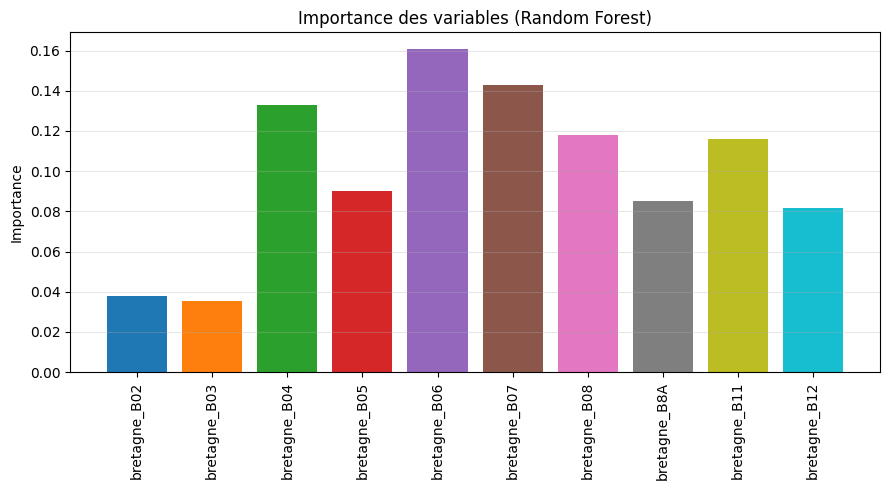

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

importances = best_model.feature_importances_

bandes_classif = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
feature_names = [f"bretagne_{b}" for b in bandes_classif]

df_imp = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances
})

display(df_imp)

# Palette de 10 couleurs distinctes
colors = cm.tab10.colors

plt.figure(figsize=(9, 5))
plt.bar(
    df_imp["Variable"],
    df_imp["Importance"],
    color=colors[:len(df_imp)]
)

plt.xticks(rotation=90)
plt.title("Importance des variables (Random Forest)")
plt.ylabel("Importance")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



L’analyse de l’importance des variables montre que les bandes red-edge (B06, B07, B05, B8A) sont les plus contributives à la classification, suivies des bandes rouge (B04), proche infrarouge (B08) et SWIR (B11, B12).

Ce résultat est cohérent avec la littérature, ces longueurs d’onde étant particulièrement sensibles à la teneur en chlorophylle, à la structure de la végétation et à la biomasse, paramètres essentiels pour discriminer les strates herbacées, les landes et les formations arborées.

À l’inverse, les bandes visibles bleue (B02) et verte (B03) présentent une contribution plus faible, ce qui est attendu pour des classes dominées par la végétation.

### Exactitude globale moyenne + écart-type

In [24]:
array_report = np.array(list_report)

mean_report = array_report.mean(axis=0)
std_report  = array_report.std(axis=0)

array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

array_acc = np.array(list_acc)
mean_accuracy = array_acc.mean()
std_accuracy = array_acc.std()

print("Accuracy moyenne :", mean_accuracy)
print("Écart-type accuracy :", std_accuracy)



Accuracy moyenne : 0.9536329313342027
Écart-type accuracy : 0.0067266127408892795


### Matrice de confusion moyenne

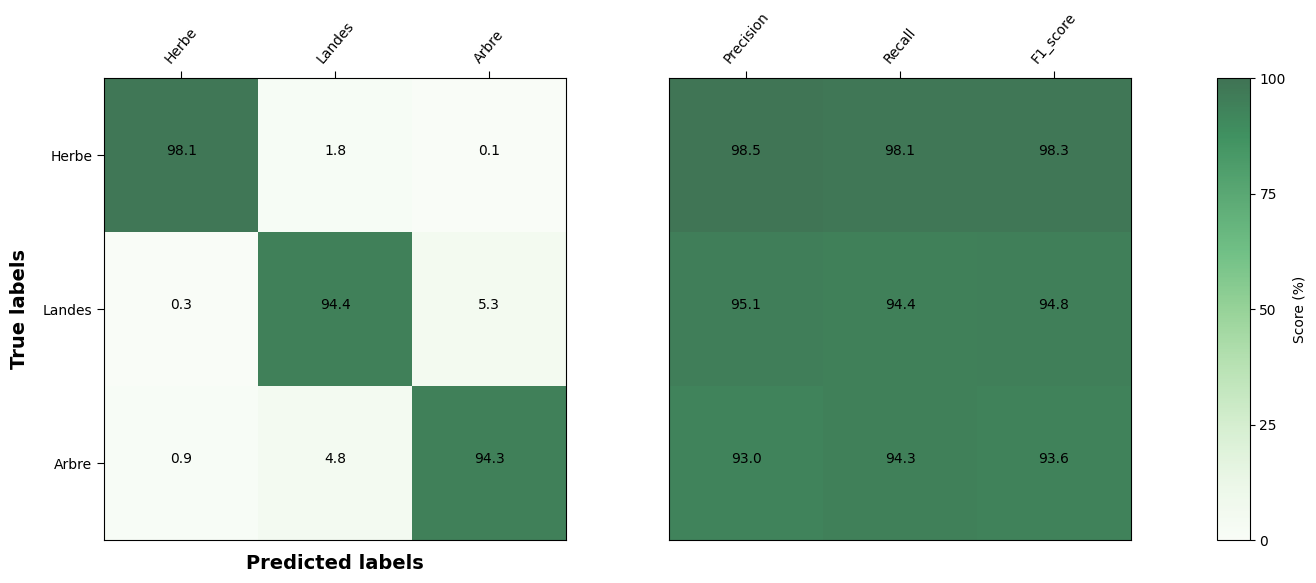

In [25]:
from libsigma import plots
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

labels = ["Herbe", "Landes", "Arbre"]

plots.plot_cm(
    mean_cm,
    labels,
    out_filename=sortie_matrix,
    normalize=True
)



### Tableau des rapports moyens

In [26]:
a_report = list_report[0]

mean_df_report = pd.DataFrame(
    mean_report,
    index=a_report.index,
    columns=a_report.columns
)

std_df_report = pd.DataFrame(
    std_report,
    index=a_report.index,
    columns=a_report.columns
)

display(mean_df_report)
display(std_df_report)



,2,3,4
precision,0.985349,0.951516,0.930314
recall,0.981392,0.944332,0.942532
f1-score,0.983320,0.947891,0.936369


,2,3,4
precision,0.010119,0.008092,0.009666
recall,0.009996,0.008545,0.011878
f1-score,0.007481,0.007149,0.010153


La classe Herbe présente les meilleures performances avec un F1-score moyen de 0.98, traduisant une très bonne séparabilité spectrale.

La classe Landes obtient également de très bons résultats (F1 ≈ 0.95), bien que légèrement inférieurs, ce qui s’explique par des confusions ponctuelles avec la classe Arbre.

La classe Arbre montre un F1-score moyen de 0.94, avec un rappel légèrement supérieur à la précision, indiquant que certains pixels de landes sont parfois classés comme arbres.

Les écarts-types faibles confirment la stabilité du modèle vis-à-vis du découpage des données d’apprentissage.

### Graphique des résultats

✅ Matrice de confusion moyenne sauvegardée : /home/onyxia/work/results/ma_matrice_CV5fold_stratified_x5times.png
✅ Graphique qualité des classes sauvegardé : /home/onyxia/work/results/mes_qualites_CV5fold_stratified_x5times.png


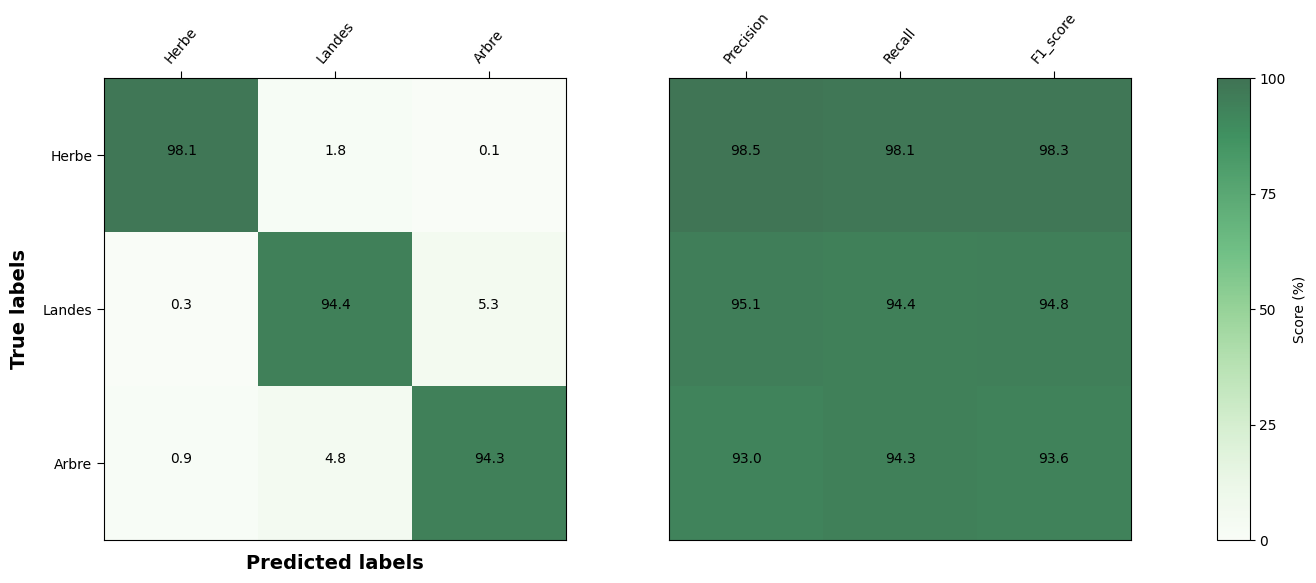

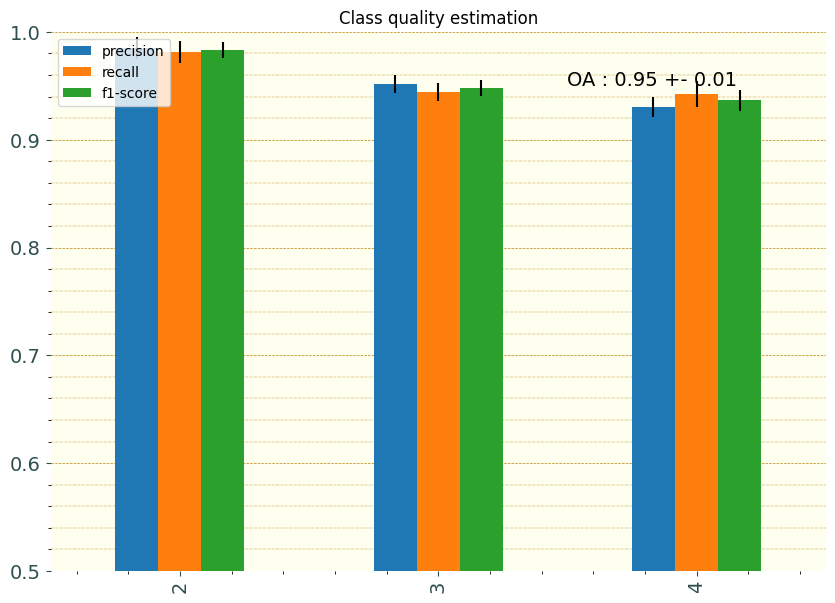

In [27]:
from libsigma import plots
import numpy as np

# =========================
# Matrice de confusion moyenne
# =========================

array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

labels = ["Herbe", "Landes", "Arbre"]

plots.plot_cm(
    mean_cm,
    labels,
    out_filename=sortie_matrix,
    normalize=True
)

print("✅ Matrice de confusion moyenne sauvegardée :", sortie_matrix)


# =========================
# Qualité moyenne des classes
# =========================

plots.plot_mean_class_quality(
    list_report,
    list_acc,
    out_filename=sortie_qualite
)

print("✅ Graphique qualité des classes sauvegardé :", sortie_qualite)


### Carte finale

In [28]:
from osgeo import gdal
import numpy as np
from libsigma import read_and_write as rw

# =========================
# Chargement image multibande
# =========================

multi_band_image_classification = "/home/onyxia/work/results/image_multibande_bretagne.tif"

image_to_be_classified = rw.load_img_as_array(multi_band_image_classification)

rows, cols, bands = image_to_be_classified.shape
print("Image shape :", image_to_be_classified.shape)

# =========================
# Mise en forme pour classification
# =========================

X_image_to_be_classified = image_to_be_classified.reshape(rows * cols, bands)

# =========================
# Prédiction pixel par pixel
# =========================

y_pred = best_model.predict(X_image_to_be_classified)

# =========================
# Reconstruction image classifiée
# =========================

classified_image = y_pred.reshape(rows, cols)

# =========================
# Sauvegarde raster final
# =========================

sortie_classif = "/home/onyxia/work/results/carte_strates.tif"

ds_ref = gdal.Open(multi_band_image_classification)
driver = gdal.GetDriverByName("GTiff")

ds_out = driver.Create(
    sortie_classif,
    cols,
    rows,
    1,
    gdal.GDT_Byte   # uint8
)

ds_out.SetGeoTransform(ds_ref.GetGeoTransform())
ds_out.SetProjection(ds_ref.GetProjection())

band = ds_out.GetRasterBand(1)
band.WriteArray(classified_image.astype(np.uint8))
band.SetNoDataValue(0)

ds_out = None
ds_ref = None

print("✅ Carte finale créée :", sortie_classif)


Image shape : (612, 1533, 10)
✅ Carte finale créée : /home/onyxia/work/results/carte_strates.tif


### Vérification nodata

In [29]:
ds = gdal.Open(sortie_classif)
band = ds.GetRasterBand(1)
print("Valeur NoData :", band.GetNoDataValue())
ds = None


Valeur NoData : 0.0
